# Cross GAN with MINE

## Import libraries

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

## Set random seed

In [32]:
def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_rand_seed(37)

## Generate 2_D cross data

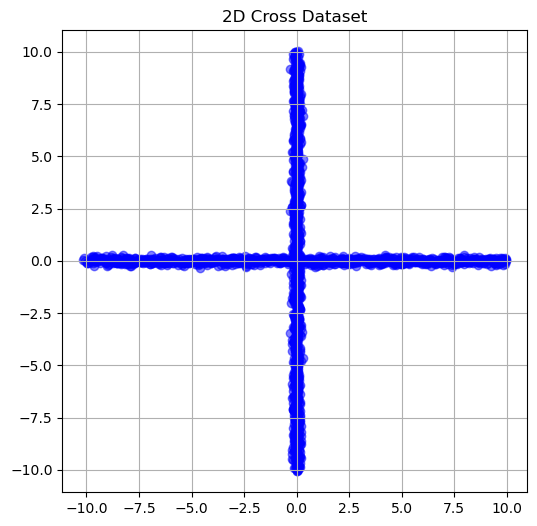

In [33]:
def generate_cross_data(num_samples, noise=0.1):
    """
    Generate 2D cross data (two perpendicular lines with Gaussian noise).

    Args:
        num_samples (int): Total number of data points to generate.
        noise (float): Standard deviation of Gaussian noise added to the data.

    Returns:
        np.ndarray: A 2D array of shape (num_samples, 2) with the cross data.
    """
    num_per_line = num_samples // 2  # Divide samples equally between two lines

    # Generate vertical line data
    x_vertical = np.zeros(num_per_line)  # x-coordinates for vertical line
    y_vertical = np.linspace(-10, 10, num_per_line)  # y-coordinates for vertical line
    vertical_line = np.vstack((
        x_vertical + np.random.normal(0, noise, num_per_line),
        y_vertical + np.random.normal(0, noise, num_per_line)
    )).T

    # Generate horizontal line data
    x_horizontal = np.linspace(-10, 10, num_per_line)  # x-coordinates for horizontal line
    y_horizontal = np.zeros(num_per_line)  # y-coordinates for horizontal line
    horizontal_line = np.vstack((
        x_horizontal + np.random.normal(0, noise, num_per_line),
        y_horizontal + np.random.normal(0, noise, num_per_line)
    )).T

    # Combine vertical and horizontal lines
    return np.vstack((vertical_line, horizontal_line))

# Generate cross data
cross_data = generate_cross_data(2000, noise=0.1)

# Plot the cross data
plt.figure(figsize=(6, 6))
plt.scatter(cross_data[:, 0], cross_data[:, 1], alpha=0.5, c='blue')
plt.title("2D Cross Dataset")
plt.grid(True)
plt.show()

## Generator

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 2),
            nn.Tanh()
        )

    def forward(self, x):
        return 12 * self.network(x)

## Discriminator

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

## MINE

In [36]:
class MINE(nn.Module):
    def __init__(self, input_dim):
        super(MINE, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x, y):
        """
        Forward pass through the MINE network.

        Args:
            x (torch.Tensor): The first set of variables (e.g., latent variables).
            y (torch.Tensor): The second set of variables (e.g., data representations).

        Returns:
            torch.Tensor: The estimated joint or marginal scores.
        """
        inputs = torch.cat((x, y), dim=1)  # Concatenate inputs along the feature dimension
        return self.network(inputs)

## Training GAN with MINE

In [37]:
n_epochs = 100
lr = 1e-3
batch_size = 64
num_samples = 5000

adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
mine = MINE(input_dim=11)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_MINE = torch.optim.Adam(mine.parameters(), lr=lr, betas=(0.5, 0.9))

Tensor = torch.FloatTensor

# Convert circle_data to PyTorch Tensor and create DataLoader
circle_tensor = torch.tensor(cross_data, dtype=torch.float32)
circle_labels = torch.ones(cross_data.shape[0], 1)
dataset = TensorDataset(circle_tensor, circle_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [38]:
def plot_generated_samples(generator, epoch, num_samples=num_samples, latent_dim=10):
    """
    Plot samples generated by the generator model.

    Args:
        generator: The generator model to generate samples.
        epoch: The current epoch number, used for title or saving purposes.
        num_samples: The number of samples to generate.
        latent_dim: The dimensionality of the random noise input to the generator.
    """
    # Generate random noise
    z = torch.randn(num_samples, latent_dim)
    z = z.to(next(generator.parameters()).device)
    # Generate data using the generator
    generated_samples = generator(z).detach().cpu().numpy()

    # Plot the distribution of generated data
    plt.figure(figsize=(6, 6))
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, c='red', label="Generated Samples")
    plt.title(f"Generated Samples at Epoch {epoch+1}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [39]:
def train_mine_gan(MI_weight):
    """
    Args:
        MI_weight (float): The weight applied to the mutual information term in the
                           generator's loss function. This controls the trade-off
                           between adversarial loss and mutual information maximization.
    """
    # Lists to store loss values and MI for plotting
    g_loss_history = []
    d_loss_history = []
    mi_history = []

    for epoch in range(n_epochs):
        for i, (x, _) in enumerate(dataloader):
            valid = Variable(Tensor(x.size(0), 1).fill_(1.0), requires_grad=False)  # Real labels
            fake = Variable(Tensor(x.size(0), 1).fill_(0.0), requires_grad=False)  # Fake labels
            z = Variable(Tensor(np.random.normal(0, 1, (x.shape[0], 10))))  # Latent dim = 10
            x_tilde = generator(z)

            # derive MI and train MINE
            optimizer_MINE.zero_grad()
            real_rep = discriminator(x)  # Representation for real samples
            fake_rep = discriminator(x_tilde.detach())  # Representation for generated samples
            joint_score = mine(z, real_rep)  # Joint distribution score
            marginal_score = mine(z, fake_rep)  # Marginal distribution score
            mine_loss = -(torch.mean(joint_score) - torch.log(torch.mean(torch.exp(marginal_score))))
            MI_estimated = -mine_loss.detach()
            mine_loss.backward()
            optimizer_MINE.step()

            # train generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(x_tilde), valid) - MI_weight * MI_estimated  # Weight mutual info by 0.1
            g_loss.backward()
            optimizer_G.step()

            # train discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(x), valid)
            fake_loss = adversarial_loss(discriminator(x_tilde.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        # Log losses and MI for this epoch
        g_loss_history.append(g_loss.item())
        d_loss_history.append(d_loss.item())
        mi_history.append(MI_estimated.item())

        if epoch % 10 == 9:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] [MI (-mine_loss): %f]"
                % (epoch+1, n_epochs, d_loss.item(), g_loss.item(), MI_estimated.item())
            )
            plot_generated_samples(generator, epoch)

    # Plot the recorded losses and MI over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), g_loss_history, label="Generator Loss (G)")
    plt.plot(range(1, n_epochs + 1), d_loss_history, label="Discriminator Loss (D)")
    plt.plot(range(1, n_epochs + 1), mi_history, label="Mutual Information (MI)", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss / MI")
    plt.title("Loss and Mutual Information over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

## Only GAN (w = 0.0)

[Epoch 10/100] [D loss: 0.433282] [G loss: 1.275300] [MI (-mine_loss): 10.436692]


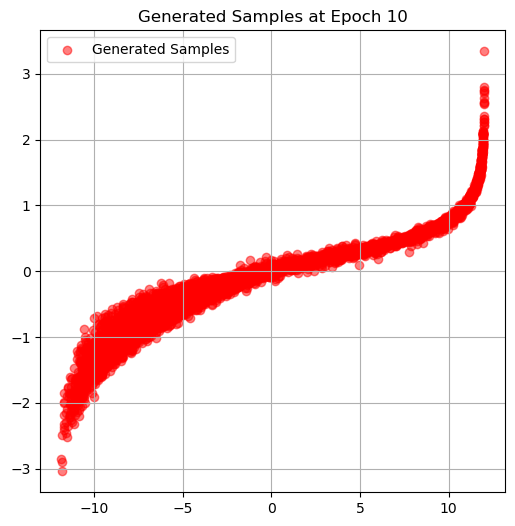

[Epoch 20/100] [D loss: 1.367398] [G loss: 0.410269] [MI (-mine_loss): -38.236355]


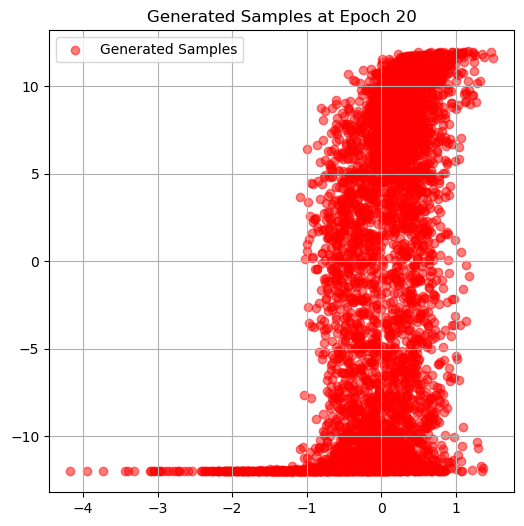

[Epoch 30/100] [D loss: 0.530550] [G loss: 0.962790] [MI (-mine_loss): 4.952241]


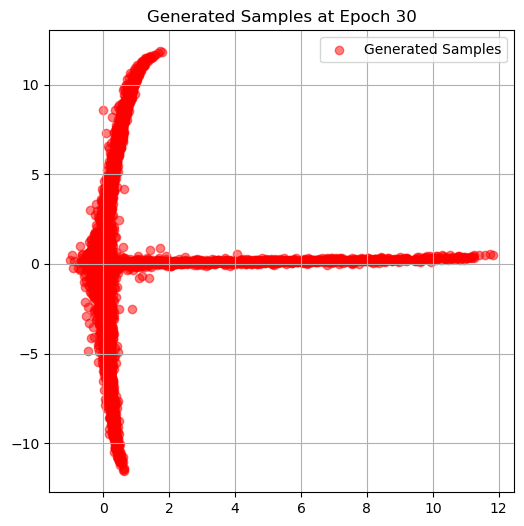

[Epoch 40/100] [D loss: 0.659932] [G loss: 0.780235] [MI (-mine_loss): 0.073881]


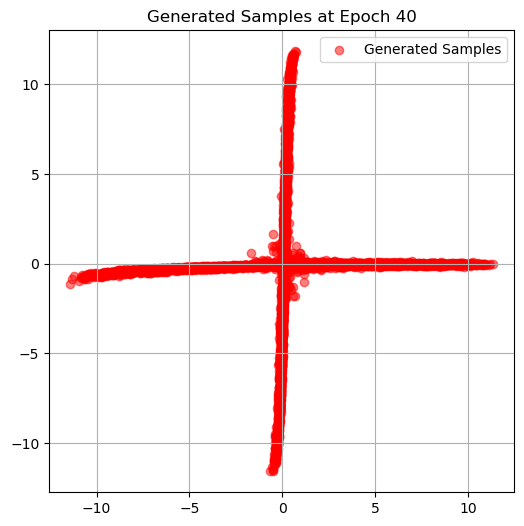

[Epoch 50/100] [D loss: 0.697547] [G loss: 0.775664] [MI (-mine_loss): 0.002842]


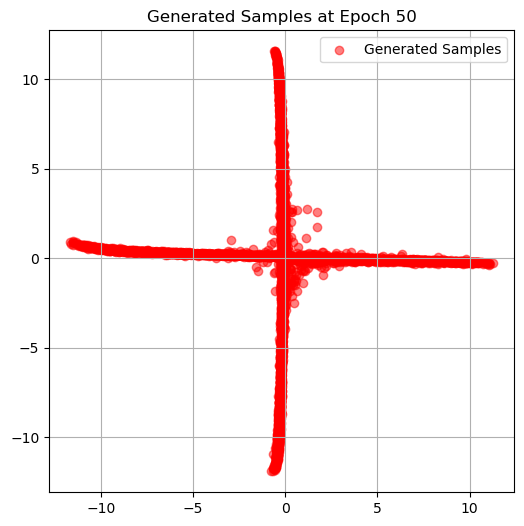

[Epoch 60/100] [D loss: 0.678826] [G loss: 0.724911] [MI (-mine_loss): 0.020937]


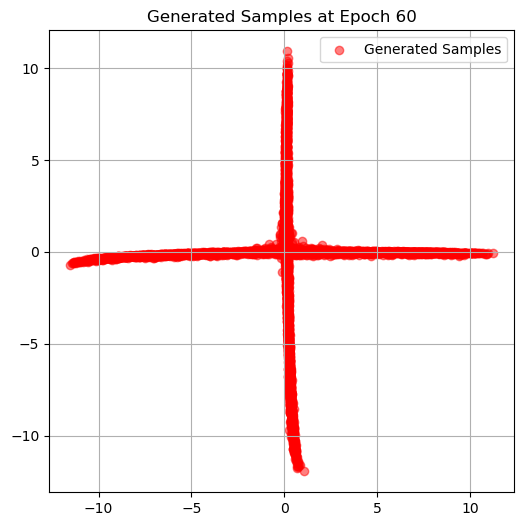

[Epoch 70/100] [D loss: 0.666193] [G loss: 0.676789] [MI (-mine_loss): 0.050630]


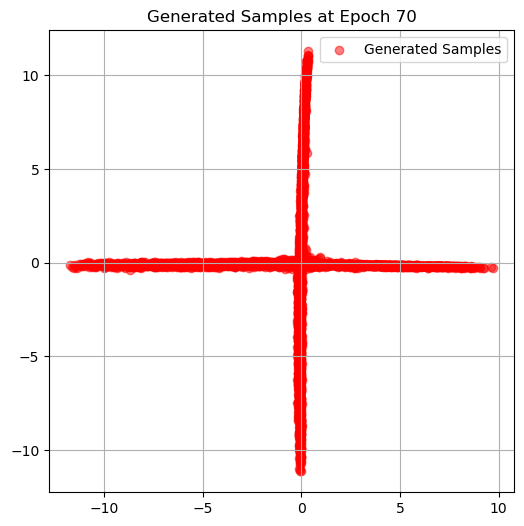

[Epoch 80/100] [D loss: 0.703502] [G loss: 0.661639] [MI (-mine_loss): -0.007331]


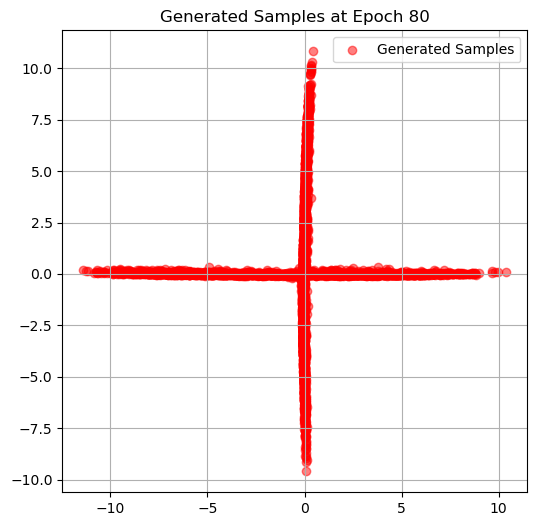

[Epoch 90/100] [D loss: 0.690275] [G loss: 0.840957] [MI (-mine_loss): 0.019718]


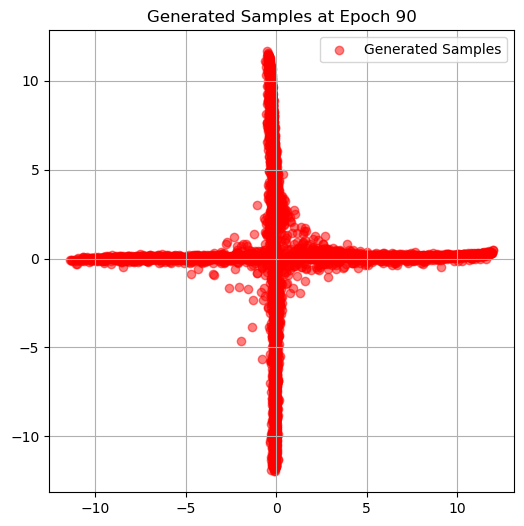

[Epoch 100/100] [D loss: 0.687870] [G loss: 0.655545] [MI (-mine_loss): 0.012159]


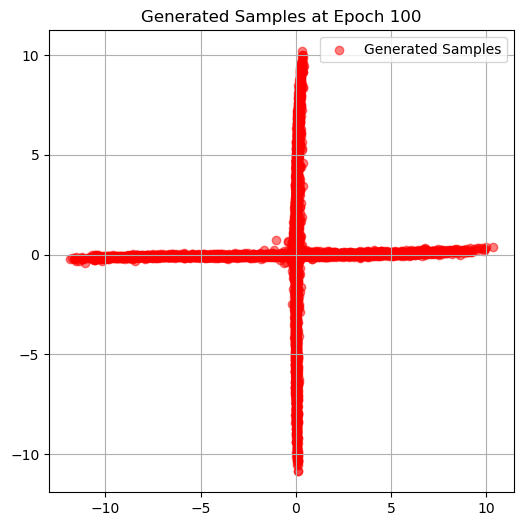

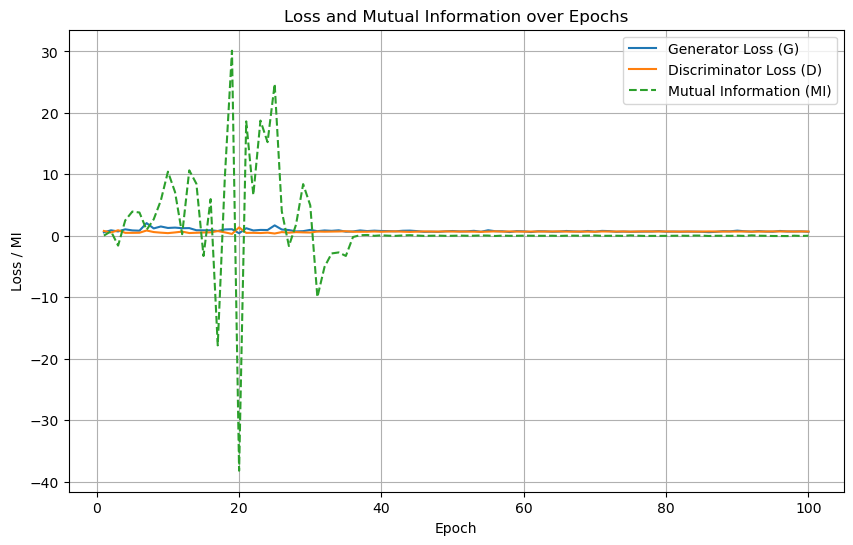

In [40]:
train_mine_gan(MI_weight=0.0)

## w = 1.0

[Epoch 10/100] [D loss: 0.678049] [G loss: 0.635641] [MI (-mine_loss): 0.066596]


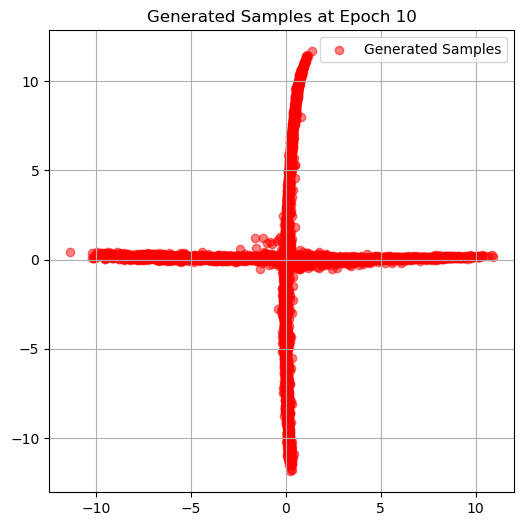

[Epoch 20/100] [D loss: 0.711236] [G loss: 0.671144] [MI (-mine_loss): -0.028429]


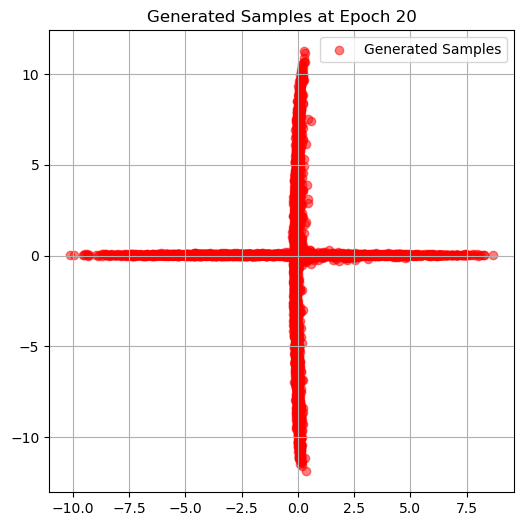

[Epoch 30/100] [D loss: 0.688381] [G loss: 0.654439] [MI (-mine_loss): 0.004456]


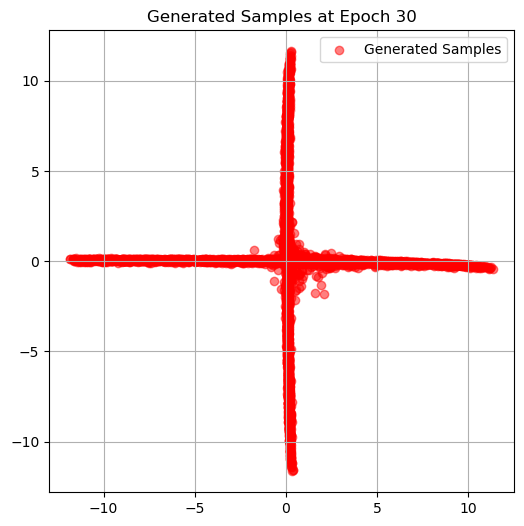

[Epoch 40/100] [D loss: 0.688017] [G loss: 0.701620] [MI (-mine_loss): 0.007053]


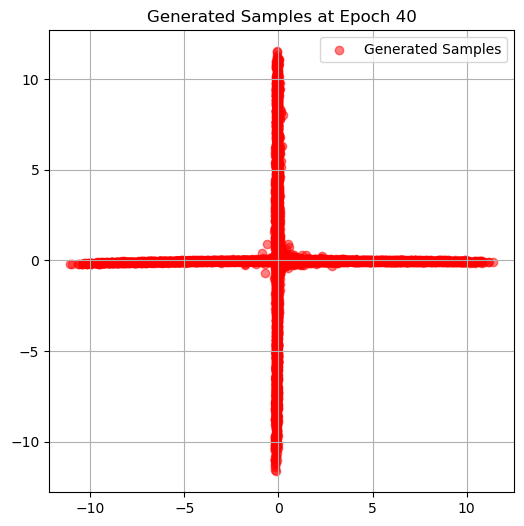

[Epoch 50/100] [D loss: 0.694603] [G loss: 0.754442] [MI (-mine_loss): -0.006590]


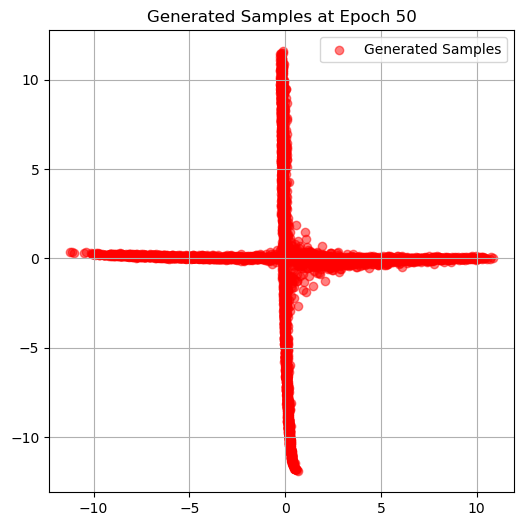

[Epoch 60/100] [D loss: 0.705099] [G loss: 0.665782] [MI (-mine_loss): 0.031981]


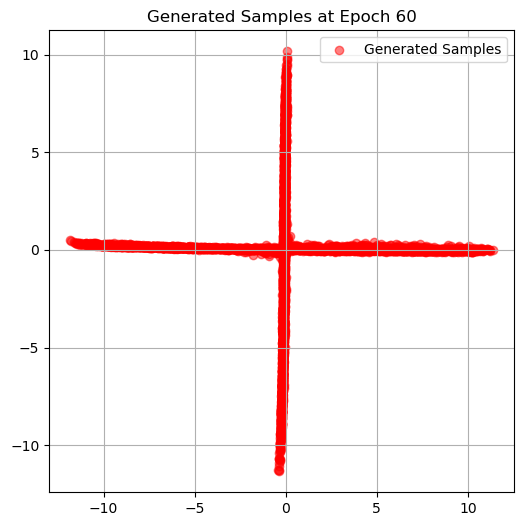

[Epoch 70/100] [D loss: 0.696354] [G loss: 0.704091] [MI (-mine_loss): -0.003632]


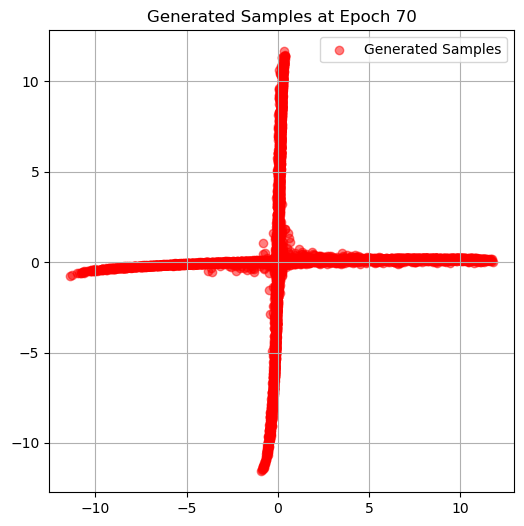

[Epoch 80/100] [D loss: 0.693421] [G loss: 0.694719] [MI (-mine_loss): 0.000505]


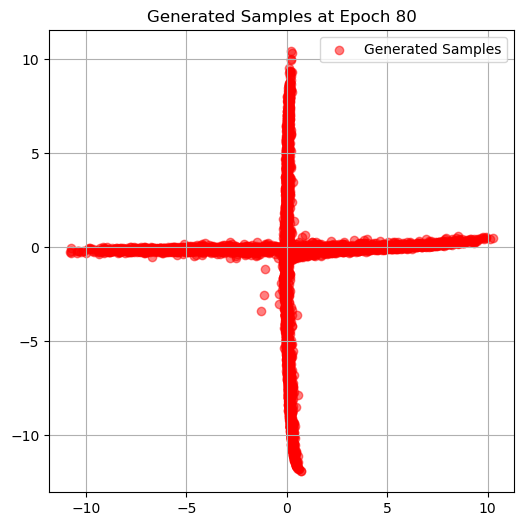

[Epoch 90/100] [D loss: 0.697569] [G loss: 0.714792] [MI (-mine_loss): -0.001597]


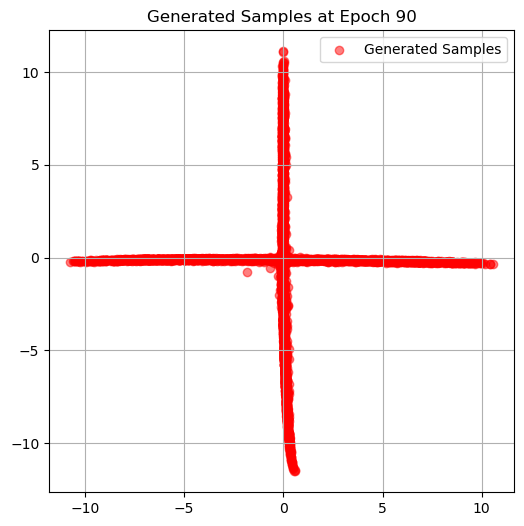

[Epoch 100/100] [D loss: 0.694460] [G loss: 0.681986] [MI (-mine_loss): 0.016344]


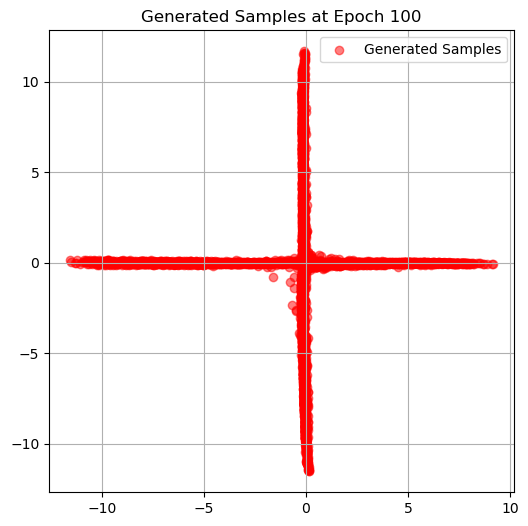

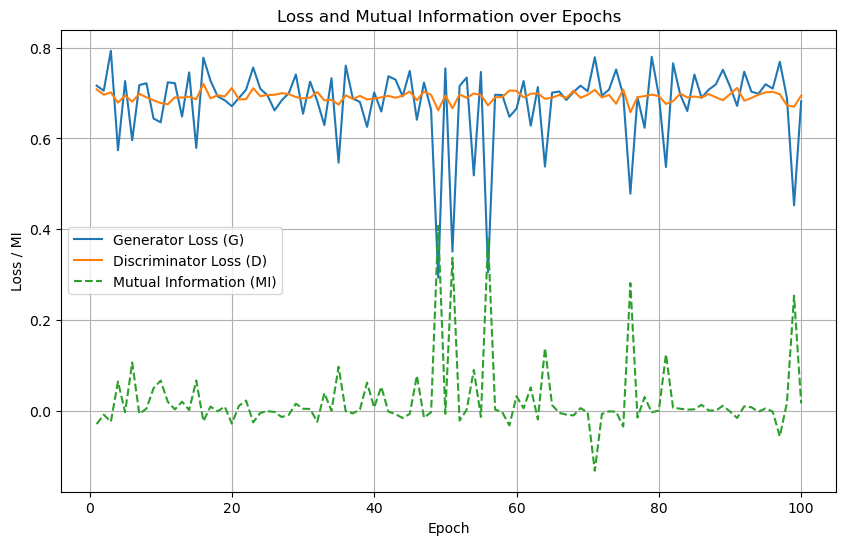

In [41]:
train_mine_gan(MI_weight=1.0)

## w = 0.1

[Epoch 10/100] [D loss: 0.687967] [G loss: 0.663945] [MI (-mine_loss): 0.048436]


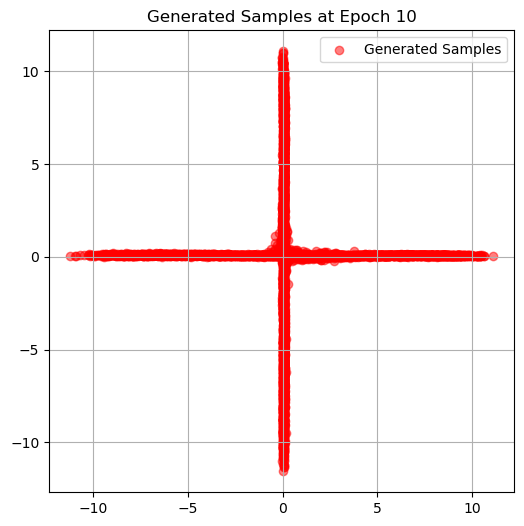

[Epoch 20/100] [D loss: 0.692691] [G loss: 0.672008] [MI (-mine_loss): 0.009154]


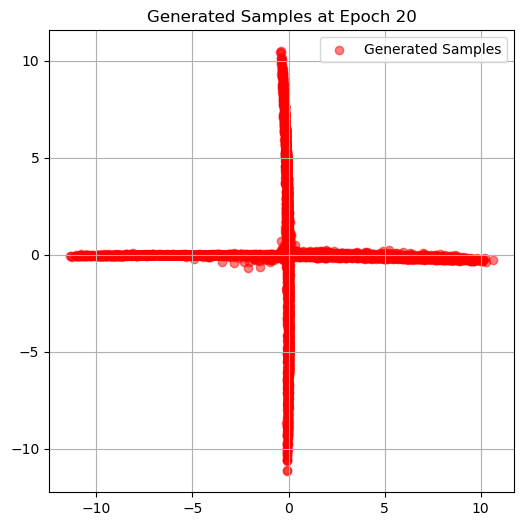

[Epoch 30/100] [D loss: 0.684514] [G loss: 0.696247] [MI (-mine_loss): 0.057307]


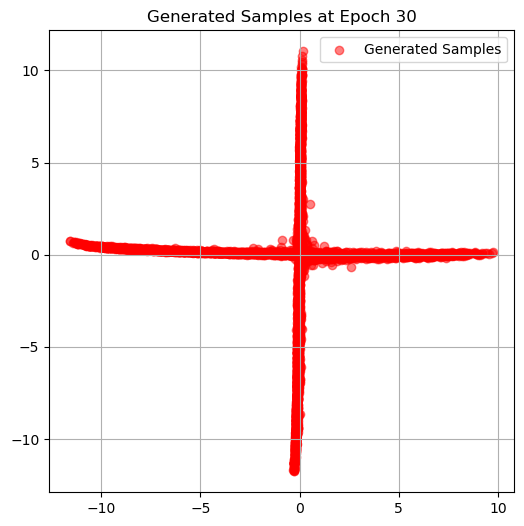

[Epoch 40/100] [D loss: 0.693491] [G loss: 0.714795] [MI (-mine_loss): -0.011984]


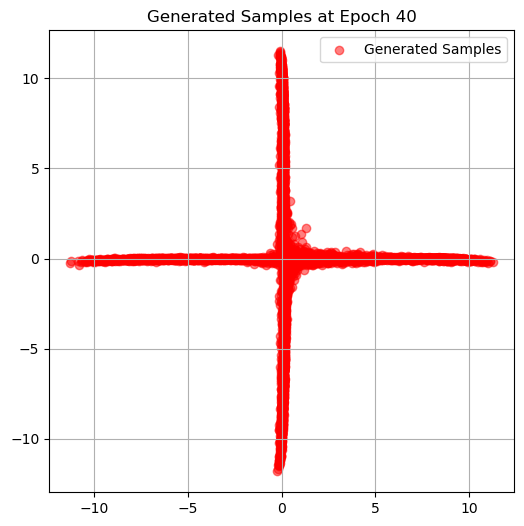

[Epoch 50/100] [D loss: 0.682540] [G loss: 0.735477] [MI (-mine_loss): -0.019987]


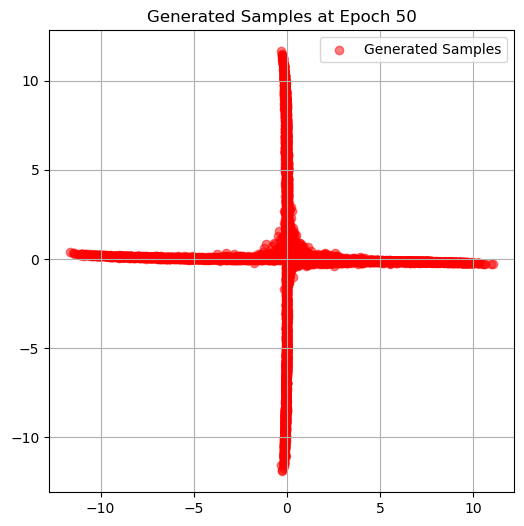

[Epoch 60/100] [D loss: 0.677541] [G loss: 0.667658] [MI (-mine_loss): 0.014524]


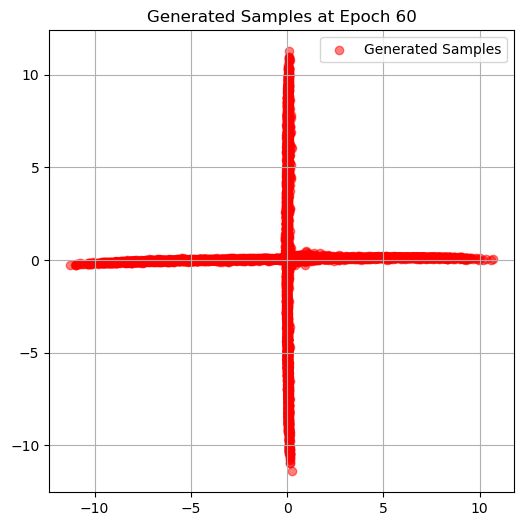

[Epoch 70/100] [D loss: 0.694318] [G loss: 0.693770] [MI (-mine_loss): -0.004323]


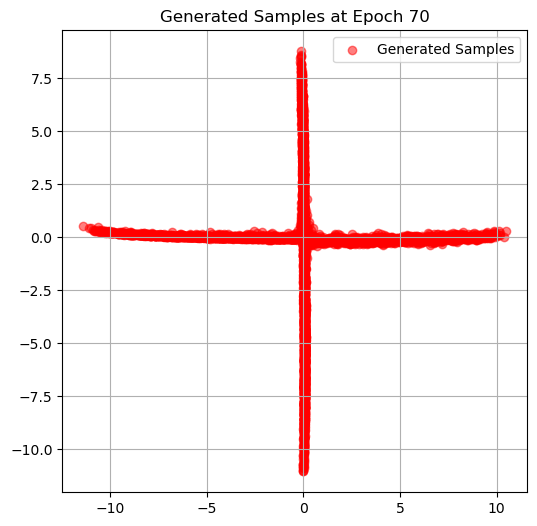

[Epoch 80/100] [D loss: 0.705221] [G loss: 0.676294] [MI (-mine_loss): 0.017853]


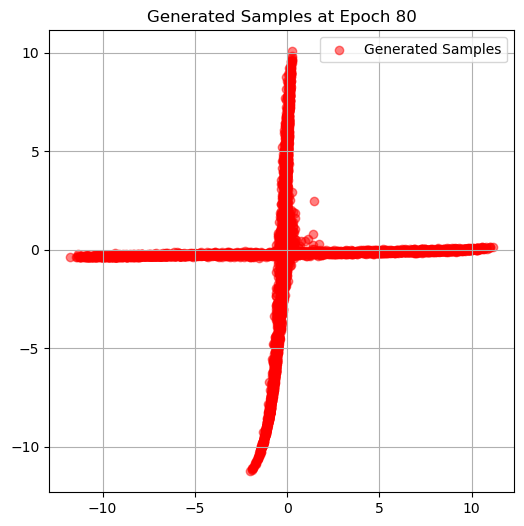

[Epoch 90/100] [D loss: 0.695949] [G loss: 0.706236] [MI (-mine_loss): -0.002448]


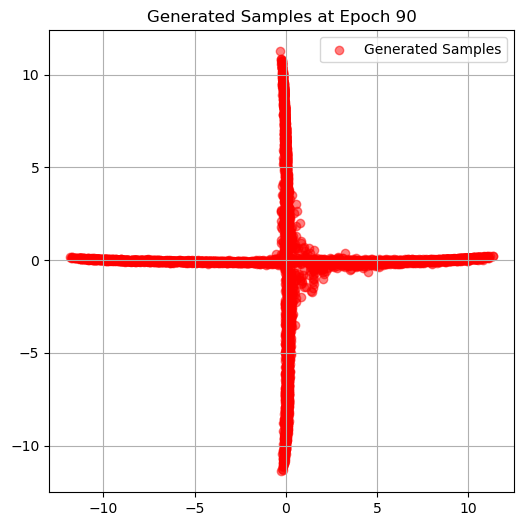

[Epoch 100/100] [D loss: 0.695036] [G loss: 0.677193] [MI (-mine_loss): 0.050774]


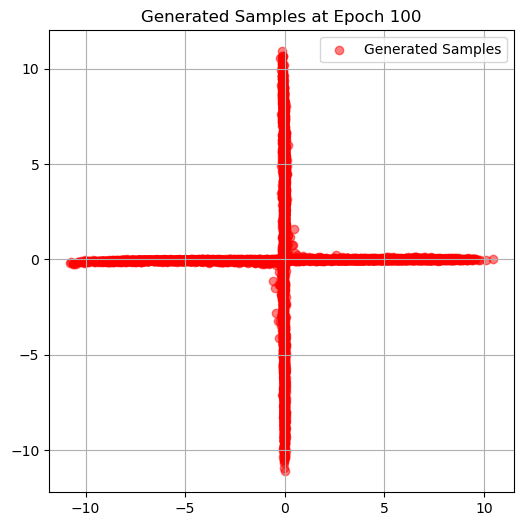

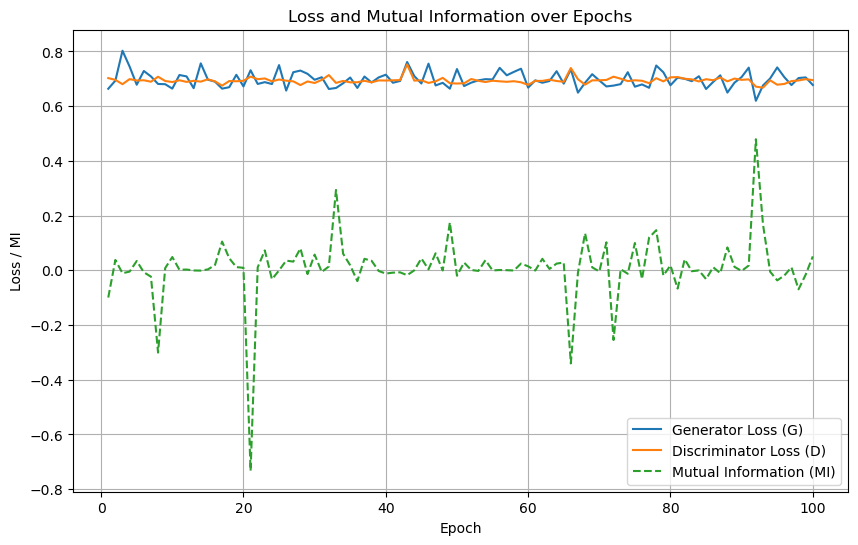

In [42]:
train_mine_gan(MI_weight=0.1)

## w = 0.01

[Epoch 10/100] [D loss: 0.690522] [G loss: 0.727643] [MI (-mine_loss): -0.013131]


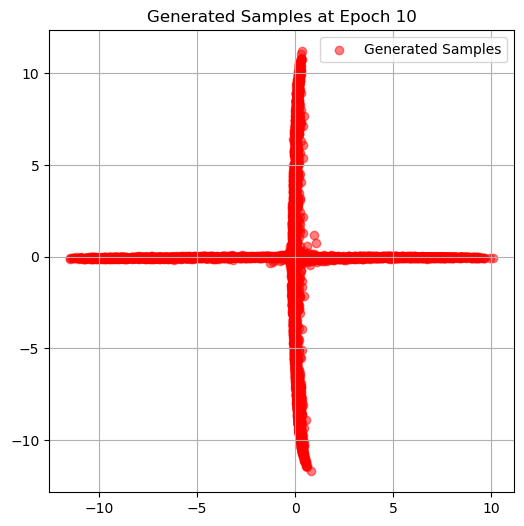

[Epoch 20/100] [D loss: 0.689914] [G loss: 0.693847] [MI (-mine_loss): 0.067061]


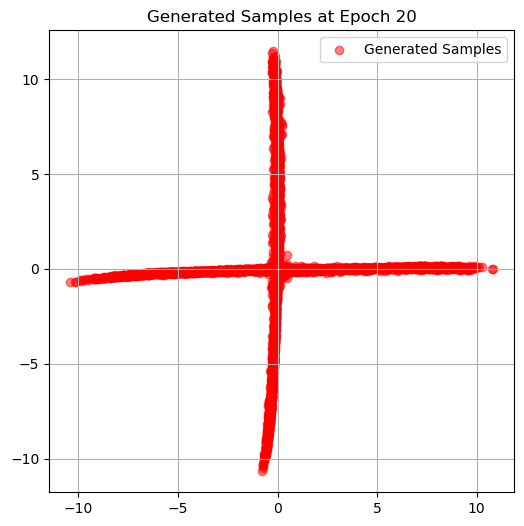

[Epoch 30/100] [D loss: 0.691986] [G loss: 0.710043] [MI (-mine_loss): -0.009889]


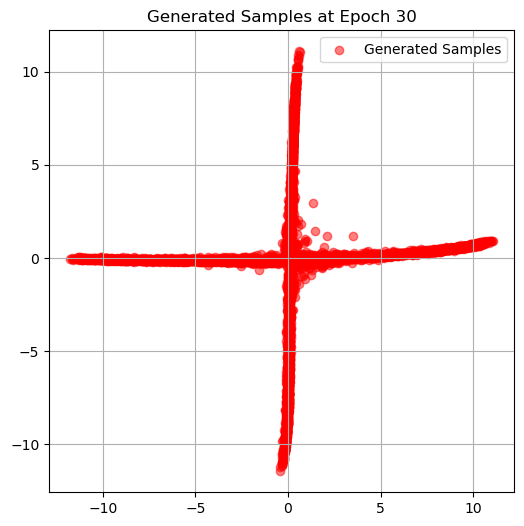

[Epoch 40/100] [D loss: 0.688116] [G loss: 0.687913] [MI (-mine_loss): 0.002768]


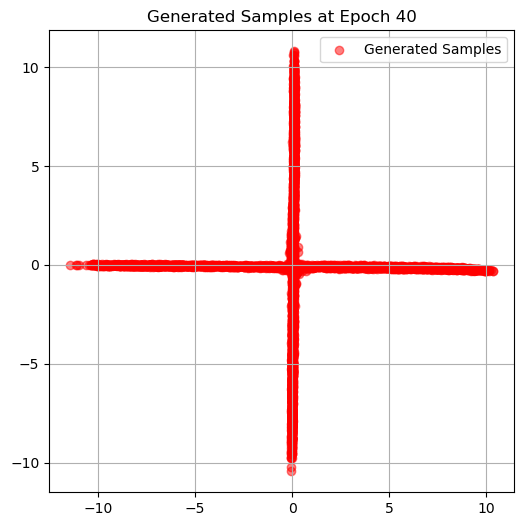

[Epoch 50/100] [D loss: 0.692635] [G loss: 0.689586] [MI (-mine_loss): -0.078253]


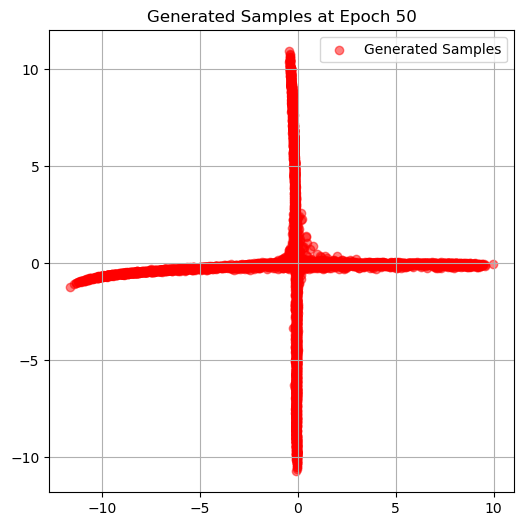

[Epoch 60/100] [D loss: 0.694900] [G loss: 0.712122] [MI (-mine_loss): 0.025553]


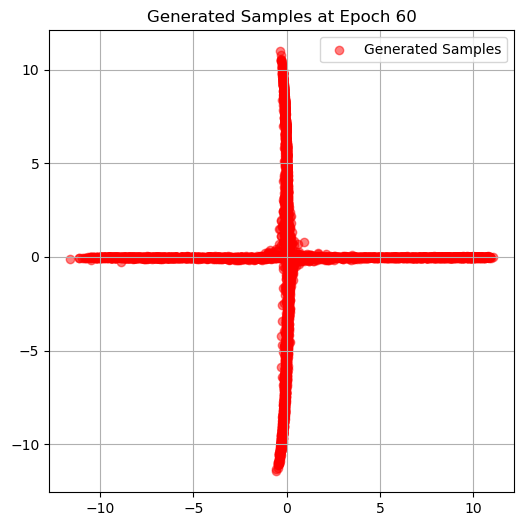

[Epoch 70/100] [D loss: 0.692072] [G loss: 0.719048] [MI (-mine_loss): -0.003833]


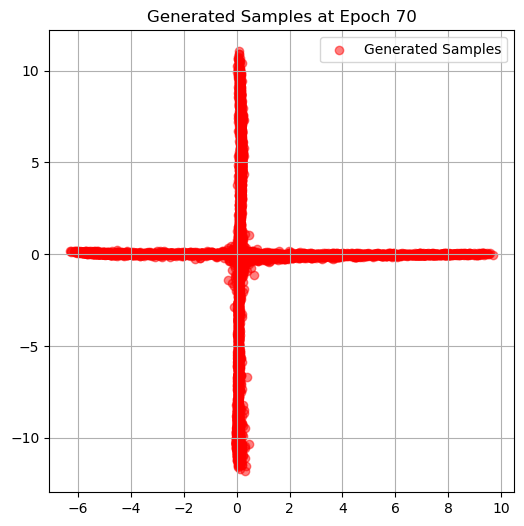

[Epoch 80/100] [D loss: 0.696857] [G loss: 0.688039] [MI (-mine_loss): -0.005294]


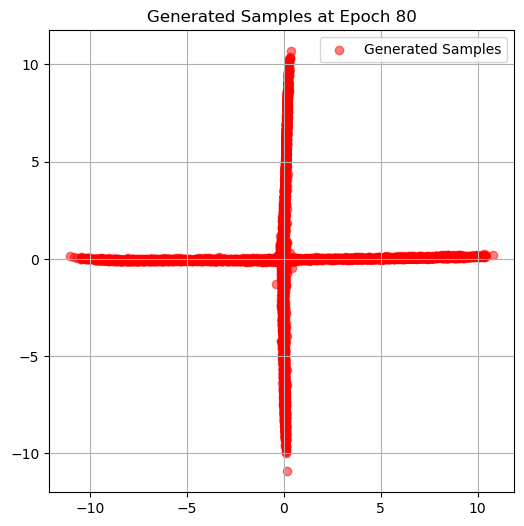

[Epoch 90/100] [D loss: 0.692296] [G loss: 0.705583] [MI (-mine_loss): 0.002454]


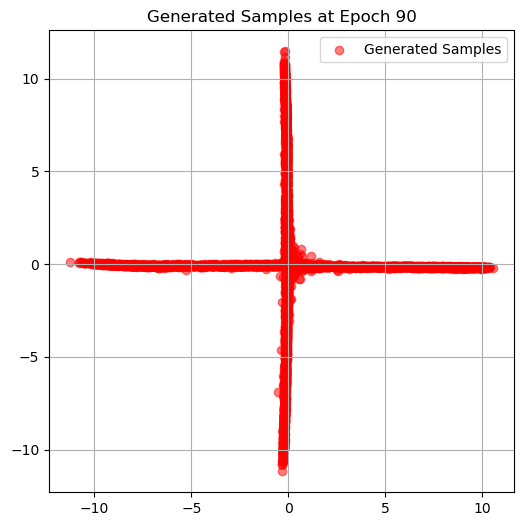

[Epoch 100/100] [D loss: 0.689299] [G loss: 0.703697] [MI (-mine_loss): -0.017552]


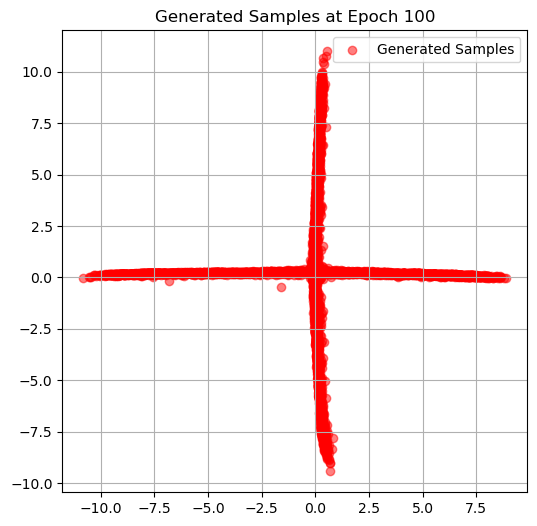

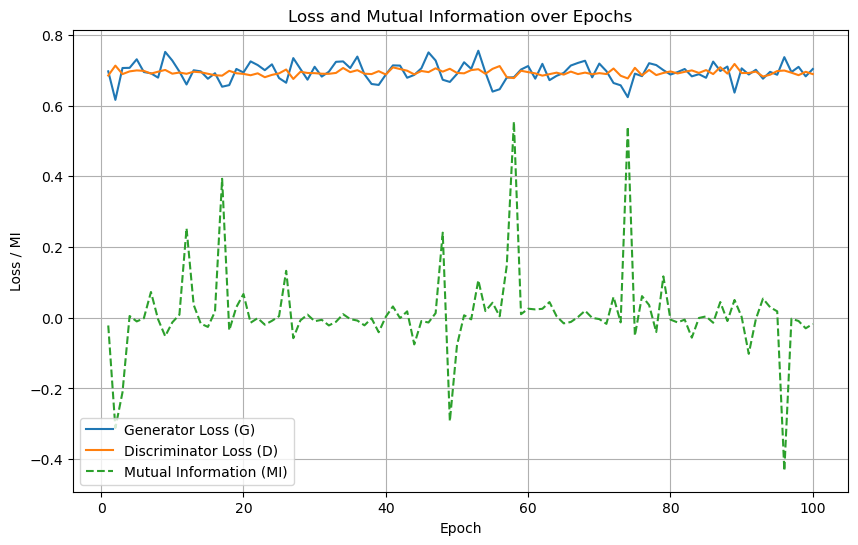

In [43]:
train_mine_gan(MI_weight=0.01)

## w = 0.001

[Epoch 10/100] [D loss: 0.689523] [G loss: 0.675736] [MI (-mine_loss): -0.022075]


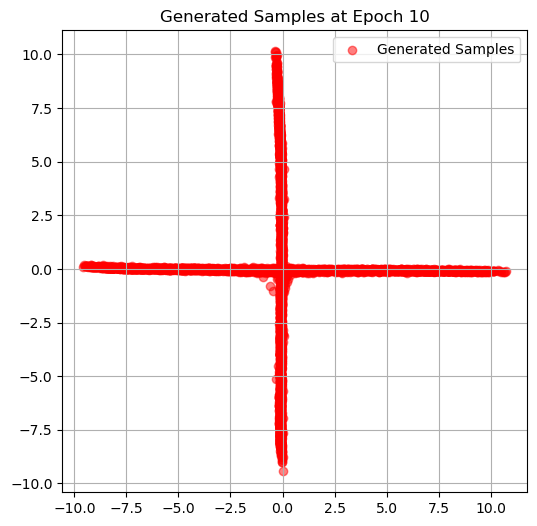

[Epoch 20/100] [D loss: 0.704583] [G loss: 0.705410] [MI (-mine_loss): 0.059186]


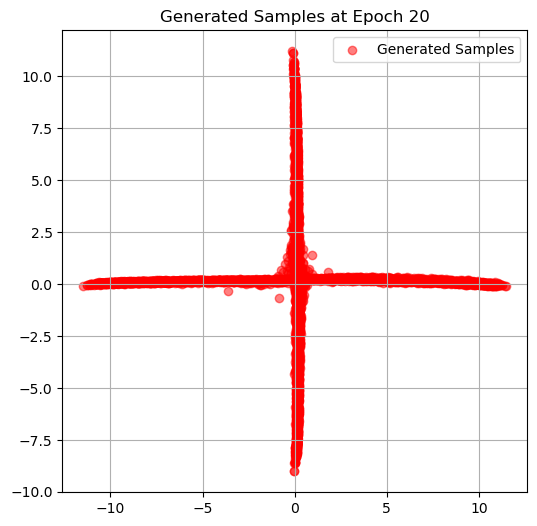

[Epoch 30/100] [D loss: 0.687635] [G loss: 0.692846] [MI (-mine_loss): -0.005349]


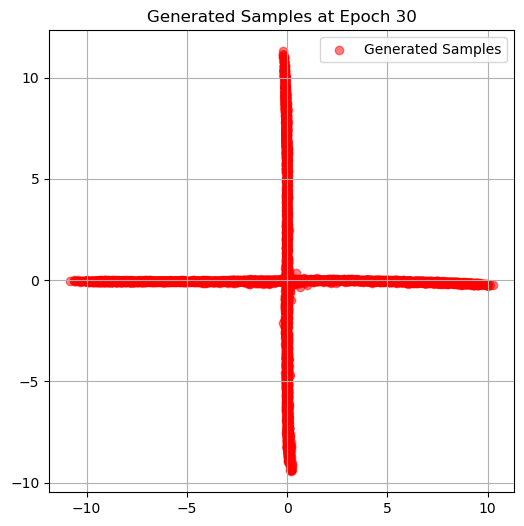

[Epoch 40/100] [D loss: 0.684891] [G loss: 0.683074] [MI (-mine_loss): -0.014489]


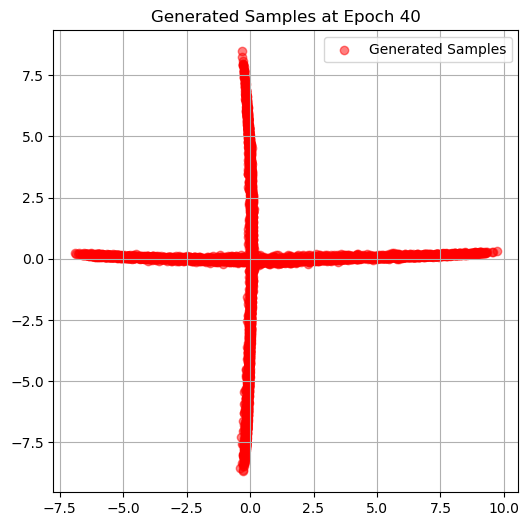

[Epoch 50/100] [D loss: 0.679606] [G loss: 0.773100] [MI (-mine_loss): 0.109055]


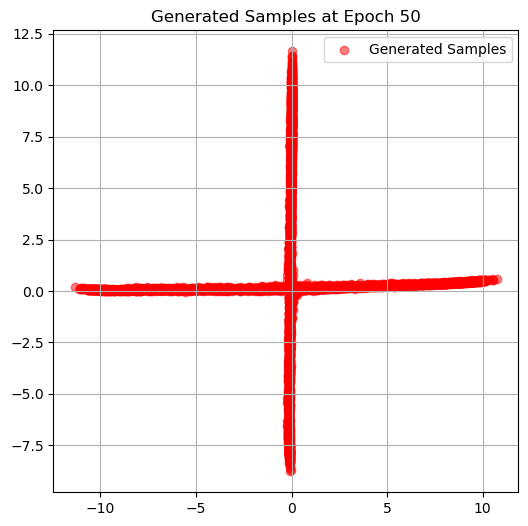

[Epoch 60/100] [D loss: 0.696738] [G loss: 0.721734] [MI (-mine_loss): 0.049868]


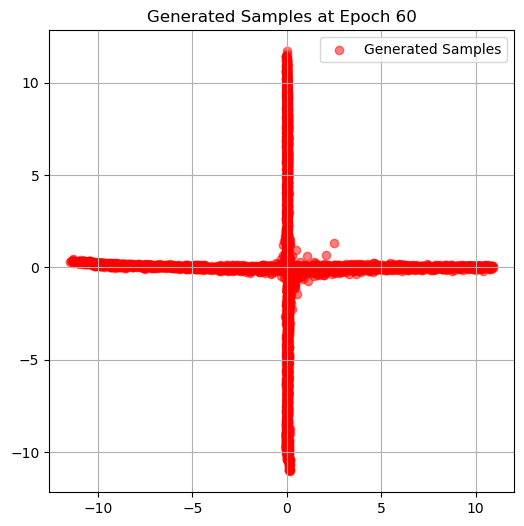

[Epoch 70/100] [D loss: 0.697560] [G loss: 0.748138] [MI (-mine_loss): 0.021357]


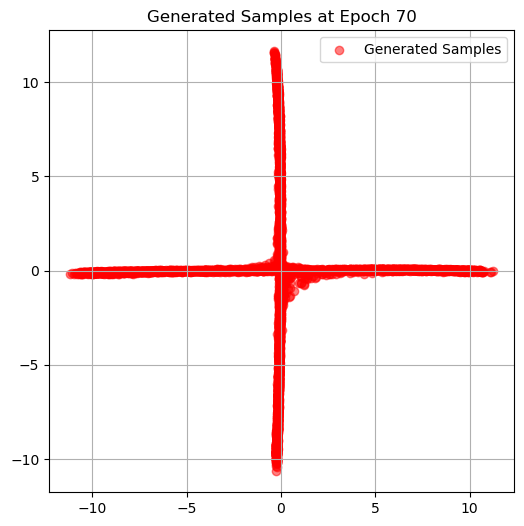

[Epoch 80/100] [D loss: 0.695183] [G loss: 0.700199] [MI (-mine_loss): 0.006903]


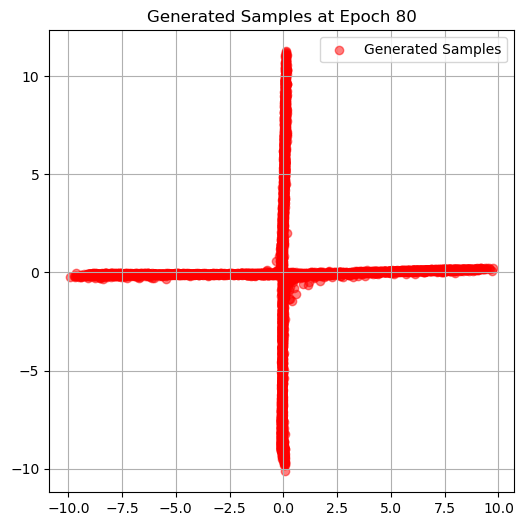

[Epoch 90/100] [D loss: 0.688456] [G loss: 0.693405] [MI (-mine_loss): -0.210782]


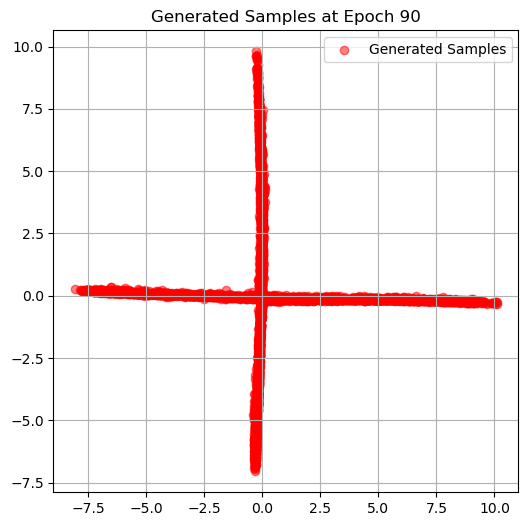

[Epoch 100/100] [D loss: 0.695169] [G loss: 0.696587] [MI (-mine_loss): -0.021808]


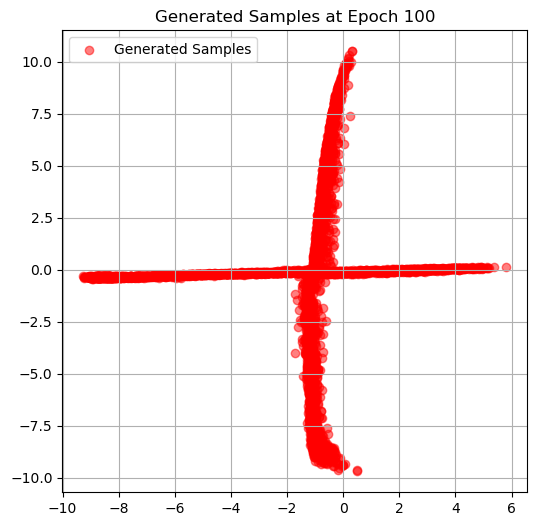

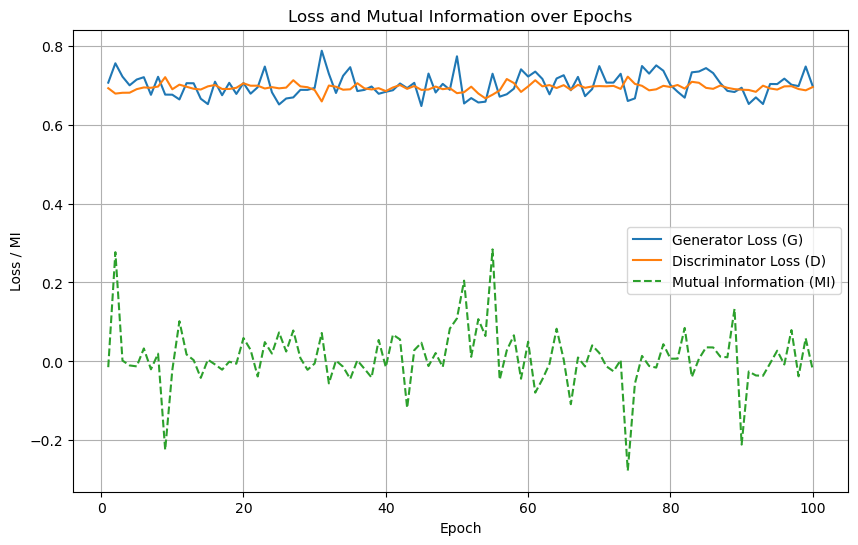

In [44]:
train_mine_gan(MI_weight=0.001)